In [287]:
# explore data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime
import geopy.distance

df_stadia = pd.read_csv('./data/stadiums.csv')
df_stadia = df_stadia[df_stadia['Country'] == 'England']
df_stadia['Team'] = df_stadia.Team.apply(str.strip)
df_stadia.set_index('Team', inplace=True)
print(df_stadia.sample(5))

df_stadia.loc['Arsenal']

                       FDCOUK        City                       Stadium  \
Team                                                                      
Colchester United  Colchester  Colchester  Colchester Community Stadium   
Gillingham F.C.    Gillingham  Gillingham                   Priestfield   
Wigan Athletic          Wigan      Wigan                    DW Stadium    
Swansea City          Swansea    Swansea               Liberty Stadium    
Coventry City        Coventry   Coventry                   Ricoh Arena    

                   Capacity   Latitude  Longitude  Country  
Team                                                        
Colchester United     10105  51.923394   0.897703  England  
Gillingham F.C.       11582  51.384250   0.560753  England  
Wigan Athletic        25133  53.547778  -2.653889  England  
Swansea City          20520  51.642200  -3.935100  England  
Coventry City         32609  52.448056  -1.495556  England  


FDCOUK                 Arsenal
City                   London 
Stadium      Emirates Stadium 
Capacity                 60361
Latitude                51.555
Longitude            -0.108611
Country                England
Name: Arsenal, dtype: object

In [288]:
df = pd.read_csv('./data/Matches.csv', low_memory=False)

## Trim and tidy the dataset >
# just EPL
df = df[df['Division'] == "E0"]
print(df.shape, "we will look at 18 months worth of data")

df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
df = df[df['MatchDate'] > "2023-06-01"]

# fixes to Team Names
df['HomeTeam'] = df['HomeTeam'].str.replace("'",'')
df['AwayTeam'] = df['AwayTeam'].str.replace("'",'')

# use this at the end to check the booky odds with our predictions
df_booky = df[['OddHome', 'OddDraw', 'OddAway']]

# prune off lots of columns we wont use - see the ReadMe for the dataset
df = df.drop(columns=['Division', 'HTHome', 'HTAway','HomeTarget','AwayTarget','HomeCorners','AwayCorners', \
                      'HomeYellow', 'AwayYellow','HomeFouls', 'AwayFouls', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw',\
                        'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize', 'HandiHome', 'HandiAway'])

# Calculate a feature measuring distance between the clubs >
# i.e. maybe far away or close by clubs makes a difference -- rivals/derby and travel factors?
# credit to this blog for the stadium data https://opisthokonta.net/?cat=34
stadia_clubnames = list(df_stadia.index.unique())  # if need debug
matches_clubnames = list(df.AwayTeam.unique()) # if need debug
#print(stadia_clubnames)
#print(matches_clubnames)
# need to fix the slightly different naming in the stadia clubnames:
df_stadia.rename(index={'A.F.C. Bournemouth':'Bournemouth', 'Brighton & Hove Albion':'Brighton', 'Ipswich Town':'Ipswich',\
                        'Leicester City':'Leicester','Luton Town':'Luton', 'Manchester City':'Man City','Manchester United': 'Man United', 'Newcastle United':'Newcastle',\
                        'Nottingham Forest':'Nottm Forest', 'Tottenham Hotspur':'Tottenham', \
                        'West Ham United':'West Ham', 'Wolverhampton Wanderers':'Wolves' }, inplace=True)

def get_distance(indx):
    coords_1 = (df_stadia.loc[df.loc[indx, 'HomeTeam'], 'Latitude'], df_stadia.loc[df.loc[indx, 'HomeTeam'], 'Longitude'])
    coords_2 = (df_stadia.loc[df.loc[indx, 'AwayTeam'], 'Latitude'], df_stadia.loc[df.loc[indx, 'AwayTeam'], 'Longitude'])
    return round(geopy.distance.geodesic(coords_1, coords_2).km, 0)
# initialise a new column to store the distance in km per match:
df['Distance'] = df.index
df['Distance'] = df['Distance'].map(lambda x:get_distance(x))
df.sample(2)

(9300, 42) we will look at 18 months worth of data


,MatchDate,MatchTime,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,FTHome,FTAway,FTResult,HTResult,HomeShots,AwayShots,HomeRed,AwayRed,Distance
228256,2025-02-22,15:00:00,Southampton,Brighton,1556.90,1765.52,3.0,3.0,3.0,9.0,0.0,4.0,A,A,6.0,18.0,0.0,0.0,92.0
224691,2024-10-05,17:30:00,Everton,Newcastle,1681.41,1810.56,4.0,4.0,4.0,8.0,0.0,0.0,D,D,8.0,14.0,0.0,0.0,192.0


In [289]:

# Do some crude feature engineering >
#
# make matchTime just the hour to treat it as a factor
df['MatchTime'] = df['MatchTime'].str.slice(0,2)
df['MatchTime'] = pd.to_numeric(df['MatchTime'], errors='coerce')


In [290]:
# More custom features that are simple to include >
#
# onehot encode the day the match was played on:
orig_columns = df.columns
df['Day'] = df['MatchDate'].dt.day_name()

df = pd.concat([df[orig_columns], pd.get_dummies(df[['Day']], dtype=int)], axis=1)
df.head(3)


,MatchDate,MatchTime,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,...,HomeRed,AwayRed,Distance,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
210362,2023-08-11,20,Burnley,Man City,1726.42,2077.27,9.0,10.0,4.0,10.0,...,1.0,0.0,34.0,1,0,0,0,0,0,0
210372,2023-08-12,12,Arsenal,Nottm Forest,1919.38,1673.98,3.0,9.0,5.0,8.0,...,0.0,0.0,169.0,0,0,1,0,0,0,0
210375,2023-08-12,15,Bournemouth,West Ham,1660.66,1779.48,0.0,3.0,3.0,6.0,...,0.0,0.0,159.0,0,0,1,0,0,0,0


In [291]:
# factorize the HTResult and FTresult too, check they are done in same way 
codes, uniques = df['FTResult'].factorize()
df['Target'] = codes - 1 # do this to have DRAW as zero
print(uniques, df.Target.value_counts())

# calculate a difference for Elo
df['EloDiff'] = (df.HomeElo - df.AwayElo).fillna(0).astype('int16')

# Restrict to the numeric columns we are going to use >
# include the dummy columns in this as well:
dummies = list(df.columns[df.columns.str.startswith('Day_')].values)
num_cols = ['MatchTime', 'Target', 'HomeRed', 'AwayRed', 'EloDiff', 'HomeShots', 'AwayShots', 'Form5Home', 'Form5Away', 'Distance'] + dummies

Index(['A', 'H', 'D'], dtype='object') Target
 0    281
-1    220
 1    149
Name: count, dtype: int64


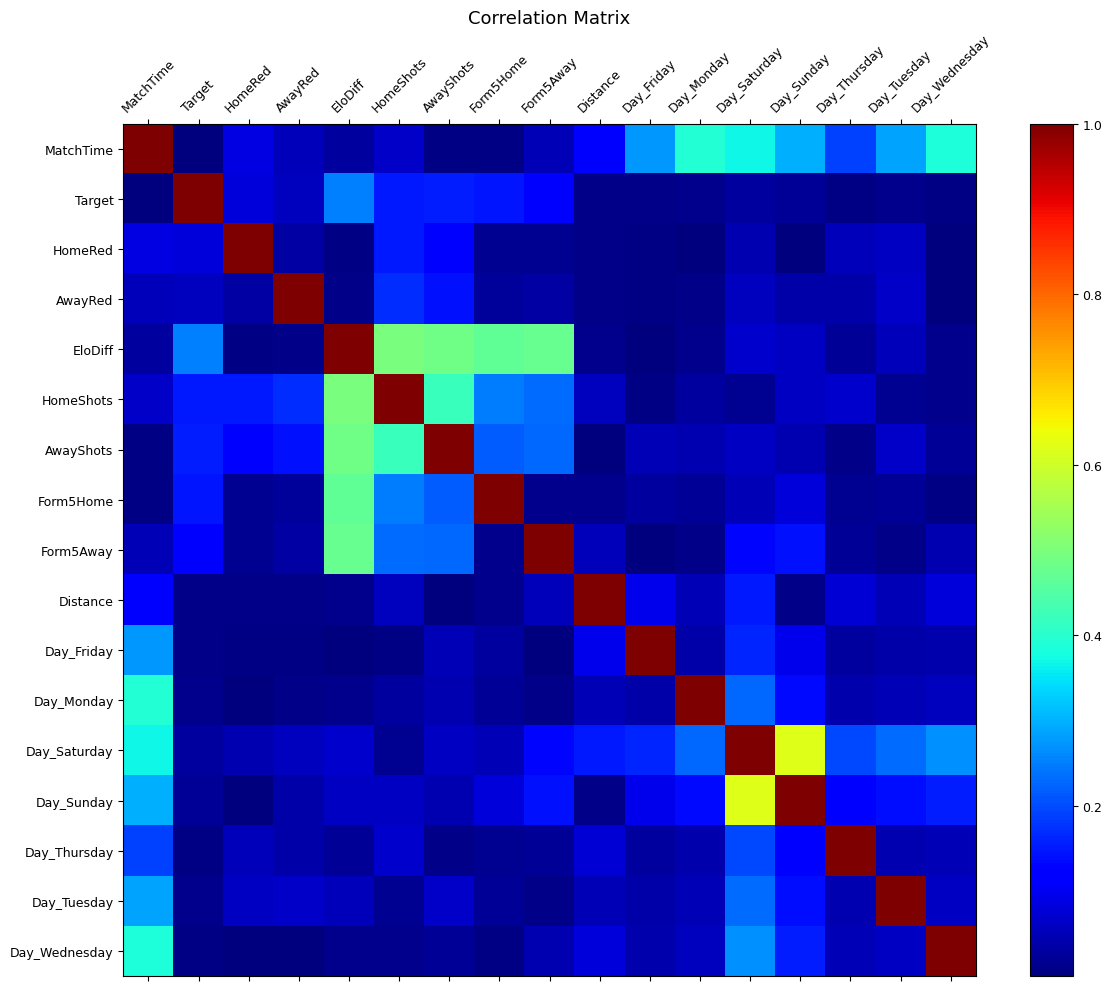

In [292]:
# visually inspect these correlations
f = plt.figure(figsize=(14, 11))

# abs() makes it a bit easier to see the correlations
plt.matshow(df[num_cols].corr().abs(), fignum=f.number, cmap='jet')
plt.xticks(range(df[num_cols].shape[1]), df[num_cols].columns, fontsize=9, rotation=45)
plt.yticks(range(df[num_cols].shape[1]), df[num_cols].columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)
plt.title('Correlation Matrix', fontsize=13);


In [293]:
# lets review some values:
print(df[['HomeTeam', 'AwayTeam','EloDiff','FTResult']].head(3))

print("\n", 'fix the NAs')
# adjust any NA that might break the learning process:
nan_rows = df.isna().any(axis=1)
print(df[nan_rows], df.shape)
df.dropna(inplace=True)

df.shape

           HomeTeam      AwayTeam  EloDiff FTResult
210362      Burnley      Man City     -350        A
210372      Arsenal  Nottm Forest      245        H
210375  Bournemouth      West Ham     -118        D

 fix the NAs
        MatchDate  MatchTime      HomeTeam      AwayTeam  HomeElo  AwayElo  \
226793 2024-12-26         15  Nottm Forest     Tottenham      NaN  1812.92   
226880 2024-12-29         15       Everton  Nottm Forest  1711.92      NaN   

        Form3Home  Form5Home  Form3Away  Form5Away  ...  Distance  Day_Friday  \
226793        0.0        0.0        3.0        4.0  ...     166.0           0   
226880        3.0        6.0        9.0       15.0  ...     135.0           0   

       Day_Monday Day_Saturday  Day_Sunday  Day_Thursday  Day_Tuesday  \
226793          0            0           0             1            0   
226880          0            0           1             0            0   

        Day_Wednesday  Target  EloDiff  
226793              0       0        0

(648, 28)

In [294]:
# 3 x target values so try a multinomial logistic regression
# concepts outlined in this example>>
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# good reference also is https://forecastegy.com/posts/train-logistic-regression-scikit-learn-python/
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# evaluate multinomial logistic regression model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std


In [295]:
# setup X data and y target labels
# before setting up the data, lets also reserve some of the later season's results to inspect our model on 
# (beyond the training and test sets we will do!)
# remove the NA rows

# TODO convert this to a filter on the date properly 
n = -32 # splits on February 2025 and sets the games after aside as a Holdout
df_numeric = df[num_cols].copy()

# remove the cols with stats from the game itself just to make things simpler
df_numeric.drop(['HomeShots', 'AwayShots','HomeRed','AwayRed'], axis=1, inplace=True)

print(df_numeric.iloc[0,:])
X = df_numeric.iloc[:n, :]
df_holdout = df_numeric.iloc[n:, :]

# the labelled outcomes are then:
y = X.Target

# ensure the y label column is removed from the dataset!
del X['Target']
X.iloc[0,:]

MatchTime         20.0
Target            -1.0
EloDiff         -350.0
Form5Home         10.0
Form5Away         10.0
Distance          34.0
Day_Friday         1.0
Day_Monday         0.0
Day_Saturday       0.0
Day_Sunday         0.0
Day_Thursday       0.0
Day_Tuesday        0.0
Day_Wednesday      0.0
Name: 210362, dtype: float64


MatchTime         20.0
EloDiff         -350.0
Form5Home         10.0
Form5Away         10.0
Distance          34.0
Day_Friday         1.0
Day_Monday         0.0
Day_Saturday       0.0
Day_Sunday         0.0
Day_Thursday       0.0
Day_Tuesday        0.0
Day_Wednesday      0.0
Name: 210362, dtype: float64

In [296]:
# preprocess data - scale / standardise as we are using Logistic Regression 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# need to split into test training before scaling to avoid leakage
# i.e. in production we would not know the mean and STD of the test!! :) 
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.25, random_state=42)

# fit scaler on the training data only:
scaler.fit(X_train)

# Transform both the training and testing data using our fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.iloc[0, :])

MatchTime         14.0
EloDiff          -97.0
Form5Home         10.0
Form5Away          5.0
Distance         229.0
Day_Friday         0.0
Day_Monday         0.0
Day_Saturday       0.0
Day_Sunday         1.0
Day_Thursday       0.0
Day_Tuesday        0.0
Day_Wednesday      0.0
Name: 225630, dtype: float64


In [297]:
# multinomial Log Reg requires a change to the loss function used to train the model (e.g. log loss to cross-entropy loss), 
# and a change to the output from a single probability value to one probability for each class label.
# TODO try with various penalties to improve the model e.g. experiment with  args penalty='l2', C=1.0

# https://scikit-learn.org/1.5/auto_examples/linear_model/plot_logistic_multinomial.html
model = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l2', C=1) # other solvers.. lbfgs / newton-cg / sag
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6168831168831169


C:\Users\batte\miniconda3\envs\pandas_ex\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [298]:
proba_test = model.predict_proba(X_test_scaled)
a = -2
b = -1

print(model.classes_) #  -1 is away win 0 is draw, 1 is home win

# print the probabilities in reverse so home win comes first!
print(np.flip(proba_test[a:b]))
print(X_test.columns)
print(X_test_scaled[a:b])


[-1  0  1]
[[0.34217955 0.53655379 0.12126666]]
Index(['MatchTime', 'EloDiff', 'Form5Home', 'Form5Away', 'Distance',
       'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
[[1.         0.66333333 0.8        0.26666667 0.2059448  0.
  1.         0.         0.         0.         0.         0.        ]]


In [299]:

y_holdout = df_holdout.Target
df_holdout = df_holdout.drop(columns='Target', axis=1, errors='ignore')
df_holdout.head()
holdout_scaled = scaler.transform(df_holdout)


In [300]:
results = ('H', 'D', 'A')

# confirm the classes order, unclear how this is established to me :/ 
print(model.classes_) #  -1 is away win 0 is draw, 1 is home win

for count, value in enumerate(y_holdout):
    row = y_holdout.index[count]
    print(df.loc[row,['MatchDate', 'Day_Saturday', 'MatchTime', 'HomeTeam', 'AwayTeam', 'EloDiff', 'HTResult', 'FTResult']].to_markdown())
    check_result = holdout_scaled[count]
    predicted = np.flip(model.predict_proba([check_result]))
    print('MODEL PREDICTION WAS:', predicted)
    print(results[np.argmax(predicted)].upper())
    print('BOOKY ODDS WERE:', df_booky.loc[row, :], "\n\n")


[-1  0  1]
|              | 227798              |
|:-------------|:--------------------|
| MatchDate    | 2025-02-03 00:00:00 |
| Day_Saturday | 0                   |
| MatchTime    | 20                  |
| HomeTeam     | Chelsea             |
| AwayTeam     | West Ham            |
| EloDiff      | 129                 |
| HTResult     | A                   |
| FTResult     | H                   |
MODEL PREDICTION WAS: [[0.33731859 0.46746543 0.19521598]]
D
BOOKY ODDS WERE: OddHome    1.36
OddDraw    5.54
OddAway    7.58
Name: 227798, dtype: float64 


|              | 227982              |
|:-------------|:--------------------|
| MatchDate    | 2025-02-12 00:00:00 |
| Day_Saturday | 0                   |
| MatchTime    | 19                  |
| HomeTeam     | Everton             |
| AwayTeam     | Liverpool           |
| EloDiff      | -277                |
| HTResult     | D                   |
| FTResult     | D                   |
MODEL PREDICTION WAS: [[0.10423211 0.30107525 0.594